This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



In [1]:
# Standard libraries
import numpy as np
import json
import sys, os
from typing import List


# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

import matplotlib.pyplot as plt
from collections import Counter



#Put your token hereIBM_TOKEN =""
CRN = "::"



In [2]:

# abs path to local quantum-gates library
LOCAL_QG_PATH = r"../../quantum-gates-main/src"
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

print("Using quantum_gates from:", LOCAL_QG_PATH)

import quantum_gates
print("Loaded quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend


Using quantum_gates from: ../../quantum-gates-main/src
Loaded quantum_gates from: c:\Users\npace\Desktop\SurfaceCode\Sem 2 work\quantum-gates-main\start up and testing\../../quantum-gates-main/src\quantum_gates\__init__.py


c:\Users\npace\Desktop\SurfaceCode\Sem 2 work\quantum-gates-main\start up and testing\../../quantum-gates-main/src\quantum_gates\_simulation\backend.py:27: SyntaxWarning: invalid escape sequence '\ '
  """Evaluates the circuits represented as tensor contractions in an trivial manner.


In [3]:
def service(ibm_token: str):
    """
    Connect to IBM Quantum service and list available backends.
    
    Parameters
    ----------
    ibm_token : str
        Your IBM Quantum API token.
    """
    backends =[]
    try:
        svc = QiskitRuntimeService(channel="ibm_quantum_platform", token=ibm_token)

        print("✅ Connected to IBM Quantum")
        print("Available backends:")
        for backend in svc.backends():
            print(f" - {backend.name}")
            backends.append(backend.name)
        return backends

    except Exception as e:
        print("❌ Failed to connect to IBM Quantum service.")
        print(f"Reason: {e}")
        return None
    

In [4]:
available_backends = service(IBM_TOKEN)
backend_name = available_backends[0]  # Select the first available backend

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-10-23 01:38:33,582: Default instance not set. Searching all available instances.


✅ Connected to IBM Quantum
Available backends:
 - ibm_brisbane
 - ibm_torino


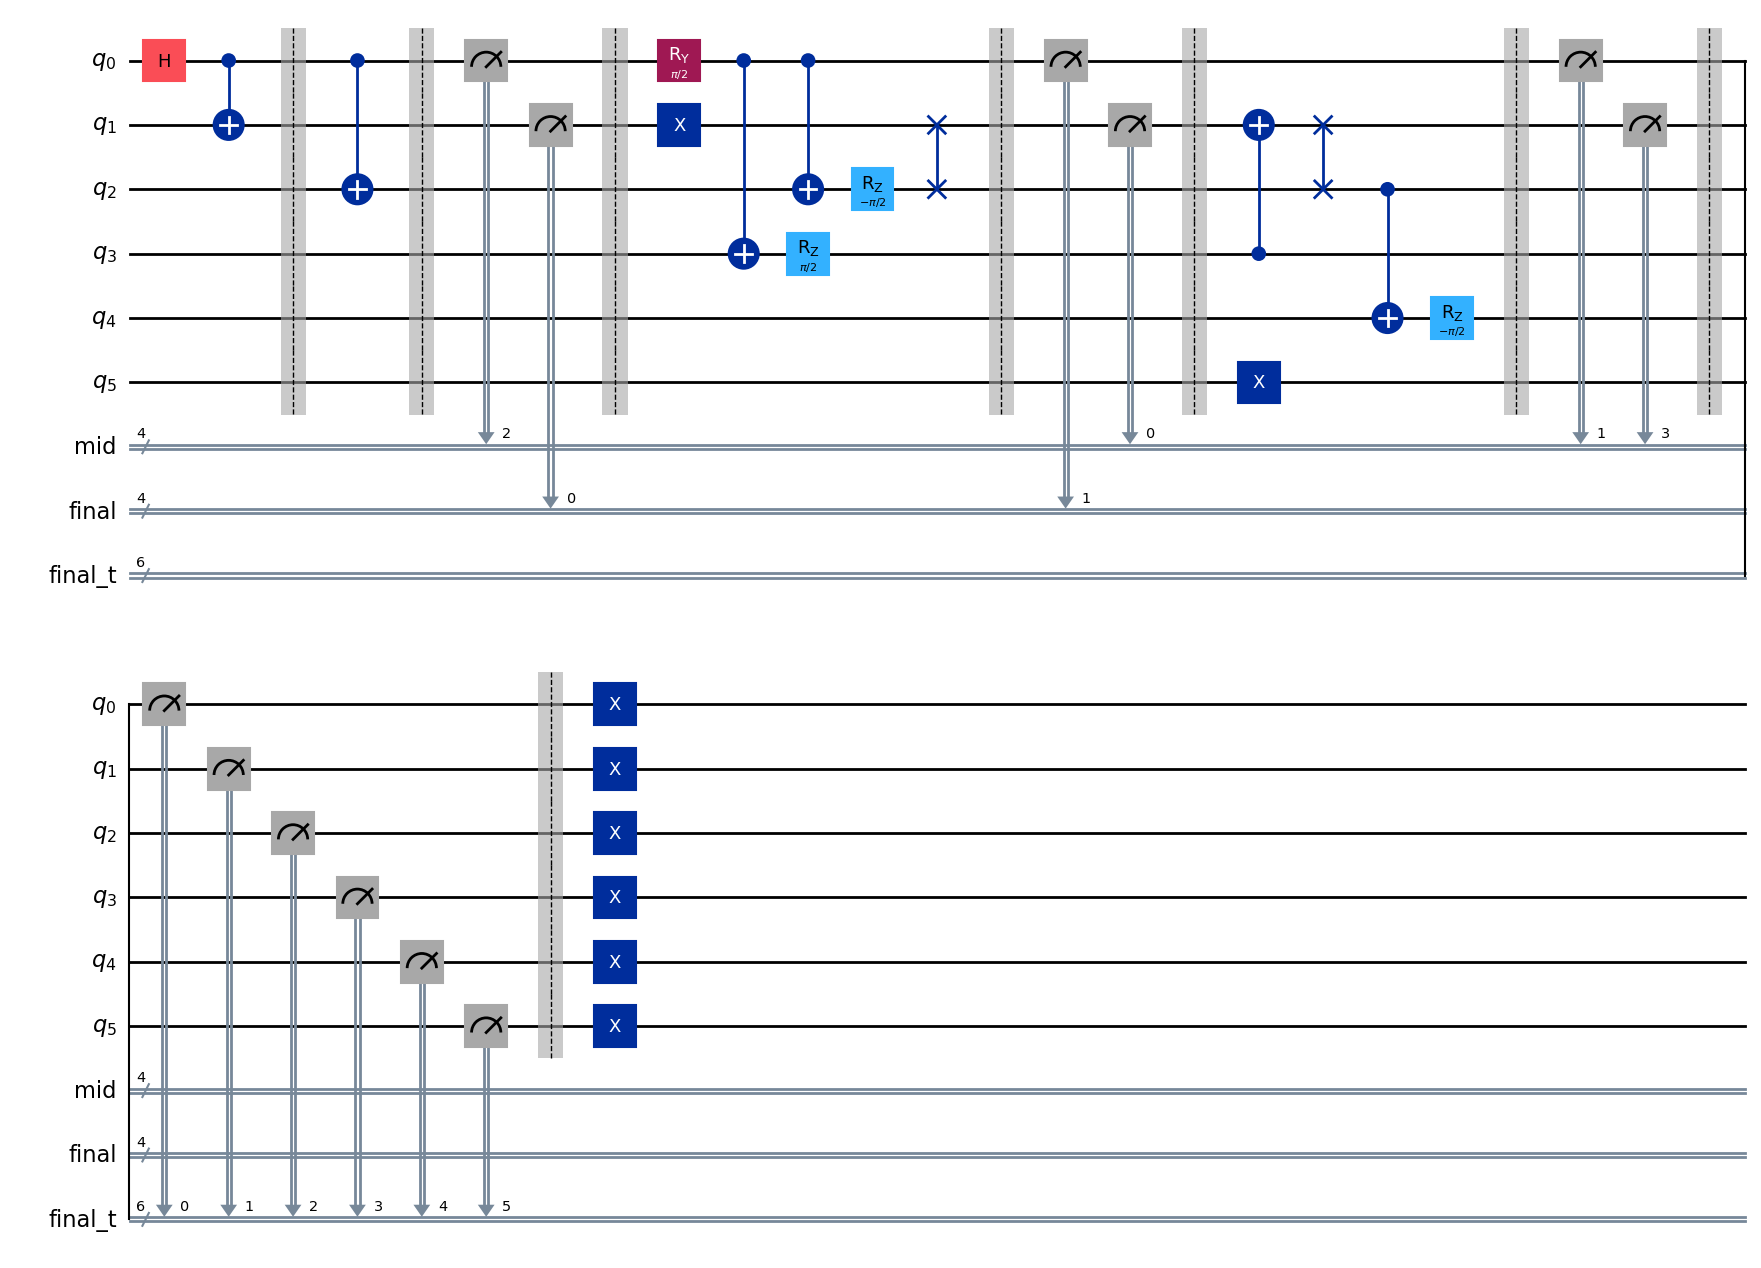

In [5]:

# Create explicit quantum and classical registers
N_q = 6 # Number of qubits in the code
N_m = 4 # Number of mid-measure classical bits

qreg = QuantumRegister(N_q, "q")
mid = ClassicalRegister(N_m, "mid")
final = ClassicalRegister(N_m, "final")
final_t = ClassicalRegister(N_q, "final_t")

# Build the circuit
qc = QuantumCircuit(qreg, mid, final, final_t)
# 1) Create a Bell state
qc.h(0)
qc.cx(0, 1)
qc.barrier()
qc.cx(0,2)
qc.barrier()
#qc.save_statevector(label="before_mid_measure")

# 2) Mid-circuit measure of qubit 0 into cbit 0
qc.measure(0, mid[2])
qc.measure(1, final[0])
qc.barrier()


# 3) Conditionally flip qubit 1 if the measurement was 1 (new control-flow API)
'''
with qc.if_test((qc.clbits[0], 1)):
    qc.x(1)
'''
qc.ry(np.pi/2, 0)
qc.cx(0,3)
#qc.reset(2)
qc.x(1)
qc.rz(np.pi/2, 3)
qc.cx(0,2)
qc.rz(-np.pi/2, 2)
qc.swap(1,2)


qc.barrier()
qc.measure(qreg[0], final[1])
qc.measure(qreg[1], mid[0])

qc.barrier()
qc.cx(3, 1)
#qc.reset(0)
qc.swap(2, 1)
qc.x(5)
qc.cx(2, 4)
qc.rz(-np.pi/2, 4)
qc.barrier()

# 4) Final measurement
qc.measure(0, 1)
qc.measure(1, 3)

qc.barrier()

qc.measure(range(N_q), final_t)
qc.barrier()

qc.x(range(N_q))


qc.draw("mpl")


In [6]:

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

#cycles = 2
initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 50

In [7]:
config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": backend_name,
        "crn": CRN
    },
    "run": {
        "shots": shots,
        "qubits_layout": initial_layout,
        "psi0": initial_psi
    }
}

In [8]:
backend_config = config["backend"]
backend = setup_backend(Token=IBM_TOKEN, **backend_config)
run_config = config["run"]

In [9]:
qubits_layout = run_config["qubits_layout"]
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
bit_flip_bool = False

In [10]:



needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

res  = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=N_q,
    bit_flip_bool=bit_flip_bool,
    )

probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
mid_counts = res["mid_counts"]


print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
#print("Final measurement probabilities:", probs)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)

---- Preprocessed data ----
Chunk 0: rz[0] , sx[0] , rz[0] , sx[0] , rz[0] , rz[1] , sx[1] , rz[1] , delay[1] , ecr[1, 0] , rz[0] , sx[0] , rz[0] , rz[1] , sx[1] , rz[1] , delay[2] , delay[3] , delay[4] , delay[5] , rz[0] , sx[0] , rz[0] , rz[1] , sx[1] , ecr[1, 0] , rz[0] , sx[0] , rz[1] , sx[1] , rz[1] , ecr[1, 0] , rz[0] , delay[0] , rz[1] , sx[1] , rz[1] , ecr[1, 0] , rz[0] , sx[0] , rz[0] , delay[0] , rz[1] , sx[1] , rz[1] , rz[2] , sx[2] , rz[2] , delay[2] , ecr[2, 1] , rz[1] , sx[1] , rz[1] , rz[2] , sx[2] , rz[2] , delay[3] , delay[4] , delay[5] , delay[2] , delay[3] , delay[4] , delay[5]
Fancy 1: mid_measurement qubits=[1] clbits=[2]
Fancy 2: mid_measurement qubits=[0] clbits=[4]
Chunk 3: x[0] , delay[0] , rz[1] , delay[1] , rz[2] , sx[2] , rz[2] , rz[3] , sx[3] , ecr[3, 2] , rz[2] , sx[2] , rz[3] , sx[3] , rz[3] , ecr[3, 2] , rz[2] , delay[2] , rz[3] , sx[3] , rz[3] , ecr[3, 2] , rz[2] , sx[2] , ecr[2, 1] , rz[1] , sx[1] , rz[1] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , s

Post processing and plotting hists

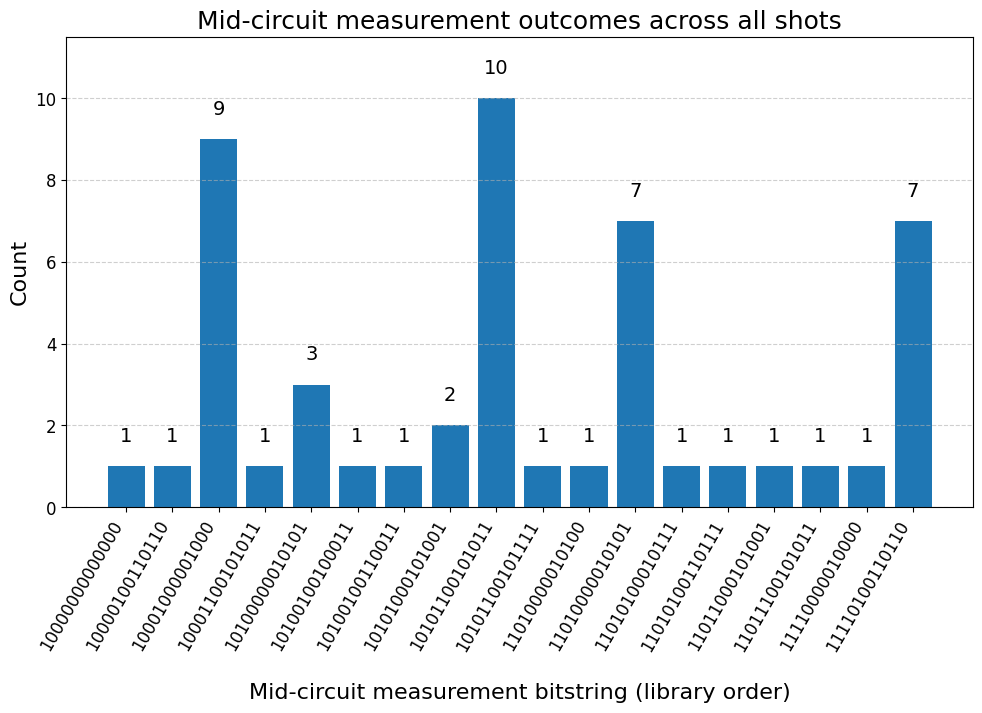

Mid-circuit measurement counts: {'10100000010101': 3, '11010100010111': 1, '10001000001000': 9, '11110000010000': 1, '10100100100011': 1, '10101100101011': 10, '11010000010101': 7, '11011000101001': 1, '11110100110110': 7, '10101000101001': 2, '11010100110111': 1, '10001100101011': 1, '10000100110110': 1, '11011100101011': 1, '10000000000000': 1, '10101100101111': 1, '11010000010100': 1, '10100100110011': 1}


In [11]:

# --- Plot histogram ---
labels = sorted(mid_counts.keys())
values = [mid_counts[k] for k in labels]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=14, color="black")

plt.xlabel("\nMid-circuit measurement bitstring (library order)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Mid-circuit measurement outcomes across all shots",fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=12)   # tilt x-axis labels

plt.show()

# --- Optional printout ---
print("Mid-circuit measurement counts:", dict(mid_counts))

Modified Hist Plot of above 5% counts 

Filtered mid-circuit measurement counts

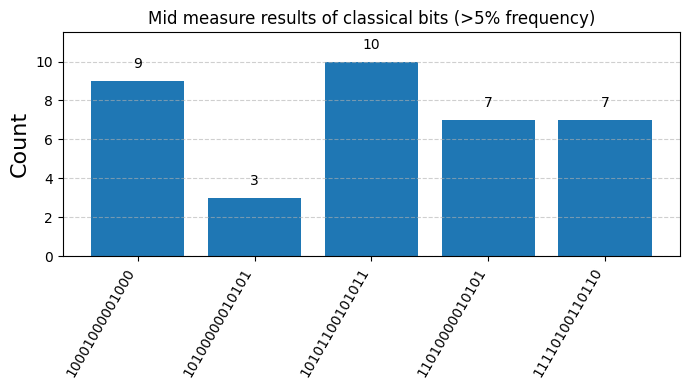

In [12]:
threshold = 0.05 * shots  # 5% cutoff

# --- Filter ---
filtered_counts = {k: v for k, v in mid_counts.items() if v >= threshold}

# --- Sort by bitstring (optional) ---
filtered_labels = list(sorted(filtered_counts.keys()))
filtered_values = [filtered_counts[k] for k in filtered_labels]

# --- Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(filtered_labels, filtered_values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(filtered_values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, filtered_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=10, color="black")

# Match Aer-style axes
plt.ylabel("Count", fontsize=16)
plt.xlabel("")  # Aer histograms usually skip x-axis label
plt.title("Mid measure results of classical bits (>5% frequency)", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout to match Aer formatting
plt.tight_layout()
plt.show()

Probabilities Generated by Final Measures

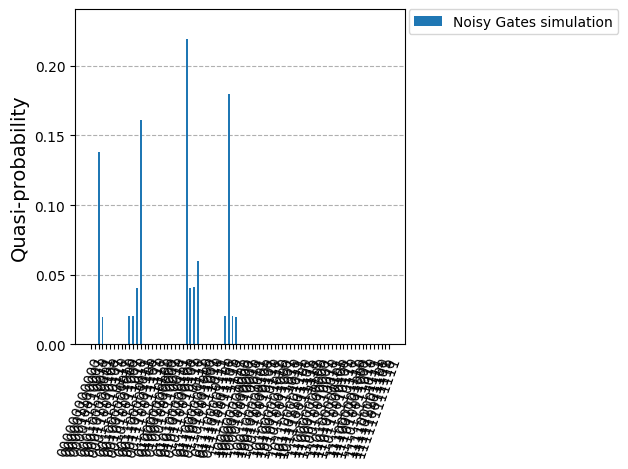

In [13]:
# Probabilities Generated by Final Measures
measured_qubit = N_m
counts_ng = fix_counts(probs, measured_qubit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

Comparison with AER

In [14]:
# Simulate with Aer
sim = AerSimulator()
t_qc = transpile(qc, sim)
result = sim.run(t_qc, shots=shots).result()
counts = result.get_counts()

Aer All clbits counts: {'101011 0010 1011': 15, '100010 0000 1000': 12, '110100 0001 0101': 14, '111101 0011 0110': 9}


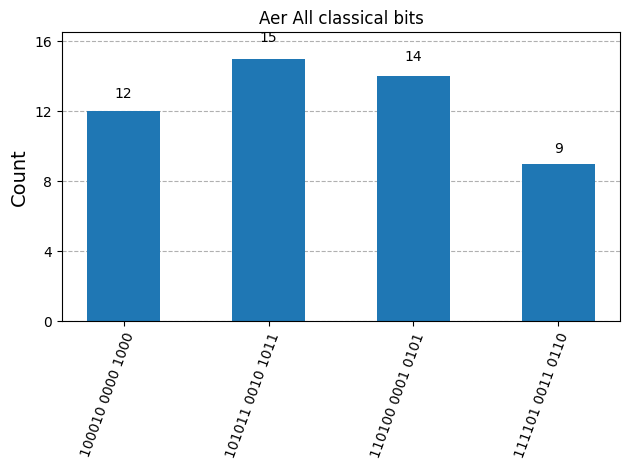

In [15]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")

Filtering Example

Truncated to final 2 bits: {'101011': 15, '001000': 12, '010101': 14, '110110': 9}


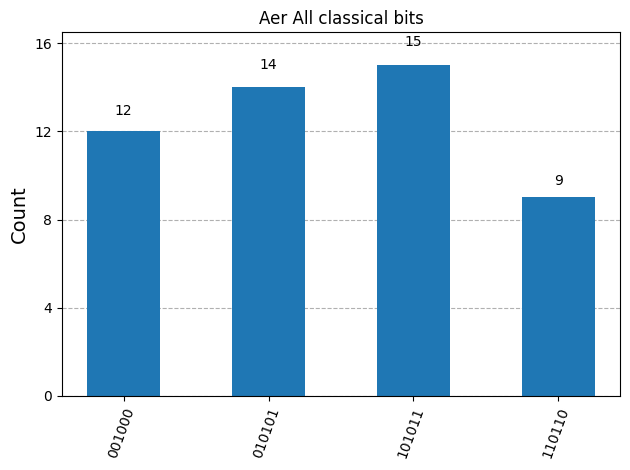

In [16]:
# Keep only the final measurement bits
final_counts = marginal_counts(counts, indices=range(N_q))

print("Truncated to final 2 bits:", final_counts)
plot_histogram(final_counts, title='Aer All classical bits')